In [85]:
import numpy as np
import math
from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
@jit
def thresh(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

In [17]:
@jit
def ssvd(X, gamu = 2, gamv = 2,u0, v0, merr = 10**(-4), niter = 100 ):
    n = X.shape[0]
    d = X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)
    while (ud > merr or vd > merr):
        #print(iters)
        iters = iters +1
        # Updating v
        z =  X.T @ u0
        winv = np.abs(z)**gamv
        sigsq = np.abs(SST - np.sum(z*z))/(n*d-d)
        cand = z*winv
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bv = np.ones(len(delt_uniq)-1)*float("inf")
        ind = np.where(winv>10^(-8))
        cand1 = cand[ind]
        winv1 = winv[ind]
        for i in range(len(Bv)):
            temp2 = thresh(cand1,delta = delt_uniq[i])
            temp2 = temp2/winv1
            temp3 = np.zeros(d)
            temp3[ind] = temp2
            Bv[i] = np.sum((X - u0.reshape(len(u0),1) @ temp3.reshape(1,len(temp3)))**2)/sigsq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== min(Bv)))  
        th = delt_uniq[Iv]
        temp2 = thresh(cand1,delta = th)
        temp2 = temp2/winv1
        v1 = np.zeros(d)
        v1[ind] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new
        
        # Updating u
        z = X @ v1
        winu = np.abs(z)**gamu
        sigsq = np.abs(SST - np.sum(z*z))/(n*d-n)
        cand = z*winu
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bu = np.ones(len(delt_uniq)-1)*float("inf")
        ind = np.where(winu > 10^(-8))
        cand1 = cand[ind]
        winu1 = winu[ind]
        for i in range(len(Bu)):
            temp2 = thresh(cand1,delta = delt_uniq[i])
            temp2 = temp2/winu1
            temp3 = np.zeros(n)
            temp3[ind] = temp2
            Bu[i] = np.sum((X - temp3.reshape(len(temp3),1) @ v1.reshape(1,len(v1)))**2)/sigsq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu==min(Bu)))
        th = delt_uniq[Iu]
        temp2 = thresh(cand1,delta = th)
        temp2 = temp2/winu1
        u1 = np.zeros(n)
        u1[ind] =  temp2
        u1 = u1/((np.sum(u1*u1))**0.5)
        
        
        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5
        
        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break
        
        u0 = u1
        v0 = v1
    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

In [18]:
data = np.loadtxt("data.txt", dtype = "float", delimiter = " ")
X = data.T
U, s, V = np.linalg.svd(X)
u0 = U.T[0]
v0 = V.t[0]
res = ssvd(X, u0 = u0, v0 = v0)

0
1
2
3
4
5


In [20]:
# rank 1 approximation 
layer = res[2] * res[0][:, None] * res[1][None, :]

In [25]:
# divide all entries by the maximum entry
layer_scaled = layer / np.max(layer)
# sort column of layer based on v
col_idx = np.argsort(res[1])
layer_sorted = layer_scaled[:, col_idx]

In [122]:
# rearrange subjects according to u within each subject group
row_idx1 = np.argsort(res[0][:20])
row_idx2 = np.argsort(res[0][21:34])+20
row_idx3 = np.argsort(res[0][34:51])+33
row_idx4 = np.argsort(res[0][51:])+51
row_idx = np.append(np.append(row_idx1, row_idx2), np.append(row_idx3, row_idx4))
layer_sorted = layer_sorted[row_idx,:]

In [190]:
# 8000 genes that have zero rank 1 approximation are excluded
layer_reduced = np.hstack([layer_sorted[:,:1462], layer_sorted[:,1462+8000:]])

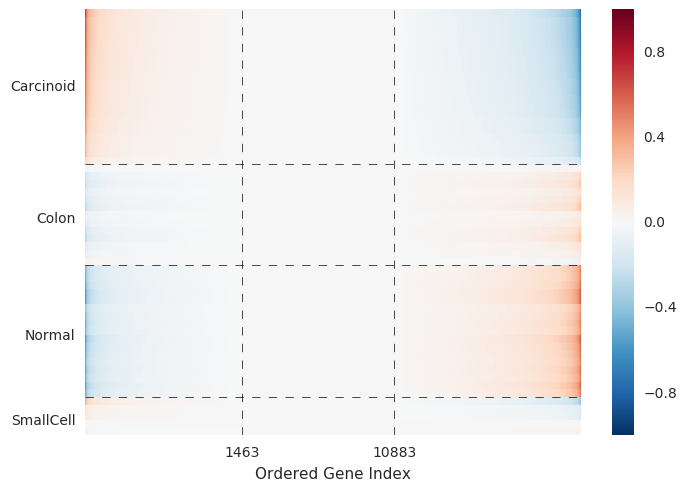

In [207]:
image1 = sns.heatmap(layer_reduced, vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
image1.set(xlabel = "Ordered Gene Index", ylabel = "")
plt.plot(list(image1.get_xlim()), [5,5], 'k--', linewidth = 0.5)
plt.plot(list(image1.get_xlim()), [22,22], 'k--', linewidth = 0.5)
plt.plot(list(image1.get_xlim()), [35,35], 'k--', linewidth = 0.5)
plt.plot([1462, 1462], list(image1.get_ylim()), 'k--', linewidth = 0.5)
plt.plot([10882-8000, 10882-8000], list(image1.get_ylim()), 'k--', linewidth = 0.5)
plt.yticks([2,13,28,45], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1462, 10882-8000], ["1463", "10883"])
plt.title("")
pass